# Charuco Camera Calibration

##### Imports

In [ ]:
import cv2
import cv2.aruco as aruco
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from PIL import Image
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# ------------------------------
ARUCO_DICT = cv2.aruco.DICT_6X6_250
SQUARES_VERTICALLY = 5
SQUARES_HORIZONTALLY = 7
SQUARE_LENGTH = 0.04
MARKER_LENGTH = 0.03

dictionary = cv2.aruco.getPredefinedDictionary(ARUCO_DICT)
board = cv2.aruco.CharucoBoard((SQUARES_VERTICALLY, SQUARES_HORIZONTALLY), SQUARE_LENGTH, MARKER_LENGTH, dictionary)
params = cv2.aruco.DetectorParameters()
charuco_detector = cv2.aruco.CharucoDetector(board)
# ------------------------------

image_files = glob.glob('./images/charuco_exp/*.jpg')

##### Helper functions

In [5]:
def load_image(image_path, resize=True):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if resize:
        image = cv2.resize(image, (image.shape[1]//4, image.shape[0]//4))
    return image

def decompose_image(image):
    marker_corners, marker_ids, _ = aruco.detectMarkers(image, dictionary, parameters=params)
    charuco_retval, charuco_corners, charuco_ids = aruco.interpolateCornersCharuco(marker_corners, marker_ids, image, board)
    if charuco_retval:
        return charuco_corners, charuco_ids, marker_corners, marker_ids
    return None, None, None, None

def decompose_image2(image):
    return charuco_detector.detectBoard(image)

def matchImagePoints(charuco_board, charuco_corners, charuco_ids):
    objPoints = []
    imgPoints = []
    for i in range(0, len(charuco_ids)):
        index = charuco_ids[i]
        objPoints.append(charuco_board.getChessboardCorners()[index])
        # objPoints[-1][0][1] = charuco_board.getRightBottomCorner()[1] - objPoints[-1][0][1]  # set old axis
        imgPoints.append(charuco_corners[i])
    return np.array(objPoints), np.array(imgPoints)

def compute_instrinsic(images, resize=True):
    '''
    Function to compute the K matrix from a directory of images
    Outputs:
    - K: camera matrix
    - df: dataframe containing marker and charuco coordinates and ids for each image
    '''
    charuco_corners_all = []
    charuco_id_all = []
    df = pd.DataFrame()
    
    for i, image_path in enumerate(images):
        image = load_image(image_path, resize=resize)
        c_corners, c_ids, m_corners, m_ids = decompose_image(image)
        
        if c_corners is not None:
            charuco_corners_all.append(c_corners)
            charuco_id_all.append(c_ids)
            
            df = pd.concat([
                df,
                pd.DataFrame({
                    'image_path': image_path,
                    'marker_id': [m_ids.squeeze()],
                    'charuco_id': [c_ids.squeeze()],
                    'marker_corners': [np.array(m_corners).squeeze()],
                    'charuco_corners': [c_corners.squeeze()]
                }, index=[i])
            ])
    
    retval, K, dist_coeffs, _, _ = aruco.calibrateCameraCharuco(
        charuco_corners_all, charuco_id_all, board, image.shape[:2], None, None
    )
    
    if retval:
        return K, dist_coeffs, df
    
def compute_P(K, R, t):
    Rt = np.hstack((R,t))
    return K @ Rt

def compute_origin_px(X_w, C, R, K):
    C = np.reshape(C, (3,1))
    X_c_t = R @ (X_w - C)

    x_c = X_c_t[0] / X_c_t[2]
    y_c = X_c_t[1] / X_c_t[2]

    u = K[0, 0] * x_c + K[0, 2]
    v = K[1, 1] * y_c + K[1, 2]

    return (int(u[0]), int(v[0]))

def plot_image_plane(K, R, t, img_width=5536, img_height=4160):
    fx, fy = K[0, 0], K[1, 1]
    cx, cy = K[0, 2], K[1, 2]
    
    z_plane = fx
    
    corners = np.array([
        [-(cx / fx) * z_plane, -(cy / fy) * z_plane, z_plane], 
        [(img_width - cx) / fx * z_plane, -(cy / fy) * z_plane, z_plane], 
        [(img_width - cx) / fx * z_plane, (img_height - cy) / fy * z_plane, z_plane],  
        [-(cx / fx) * z_plane, (img_height - cy) / fy * z_plane, z_plane]
    ], dtype=np.float64)
    
    t = t.reshape(3, 1)  
    corners_world = (R.T @ corners.T + t).T  
    
    C = -R.T @ t
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    img_plane = Poly3DCollection([corners_world], alpha=0.5, color='blue')
    ax.add_collection3d(img_plane)
    
    ax.scatter(*C.flatten(), color='red', label="Camera Center")
    
    for corner in corners_world:
        ax.plot([C[0, 0], corner[0]], [C[1, 0], corner[1]], [C[2, 0], corner[2]], 'k--')
    
    # Set plot limits and labels
    ax.set_xlim([-2, 2])
    ax.set_ylim([-2, 2])
    ax.set_zlim([-2, 2])
    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")
    ax.set_zlabel("Z-axis")
    ax.legend()
    plt.show()

##### Single Image Decomposition

In [14]:
# K, dist_coeffs, df = compute_instrinsic(image_files, resize=False)
K = np.array([
       [9.15174127e+03, 0.00000000e+00, 2.42775362e+03],
       [0.00000000e+00, 9.10725194e+03, 2.15567590e+03],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]
])
dist_coeffs = np.array([[-9.91043732e-02, -1.59405374e-02,  1.91785932e-03, -8.15007677e-03,  1.37990032e+01]])

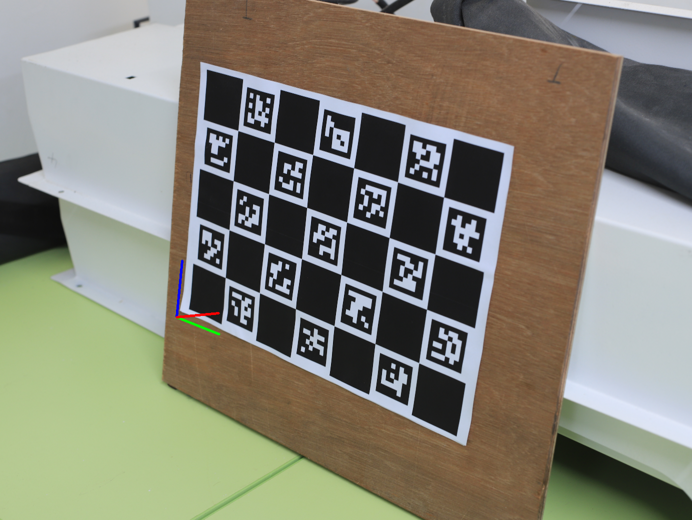

In [15]:
i = 4
image = load_image(image_files[i])
# charuco_corners, charuco_ids, marker_corners, marker_ids = decompose_image(image)
charuco_corners, charuco_ids, marker_corners, marker_ids = decompose_image2(image)
objPoints, imgPoints = matchImagePoints(calibration_board, charuco_corners, charuco_ids)
valid, rvec, tvec = cv2.solvePnP(objPoints, imgPoints, K, dist_coeffs)
img_result = cv2.drawFrameAxes(np.copy(image), K, dist_coeffs, rvec, tvec, 0.08)

# retval, rvec, tvec = cv2.aruco.estimatePoseCharucoBoard(charuco_corners, charuco_ids, board, K, dist_coeffs, None, None)

# R, _ = cv2.Rodrigues(rvec)
# P = compute_P(K, R, tvec)

# C = -R.T @ tvec

# cx, cy = K[0, -1], K[1, -1]

# computed_origin = compute_origin_px(
#     np.array([[0,0,0]], dtype=np.float32),
#     C, R, K
# )
# point_11 = compute_origin_px(
#     np.array([[1,0,0]], dtype=np.float32),
#     C, R, K
# )

# cv2.circle(image, computed_origin, 10, (255, 0, 0), -1)
# cv2.circle(image, point_11, 10, (0, 255, 0), 20)
# cv2.circle(image, (int(cx), int(cy)), 10, (0, 0, 255), -1)

# print("Projection matrix P:\n", P, '\n')
# print("Camera matrix K:\n", K, '\n')
# print("Rotation matrix R:\n", R, '\n')
# print("Translation vector t:\n", tvec, '\n')
# print("Camera position:\n", C, '\n')
# print("World point:", point_11, '\n')

# aruco.drawDetectedMarkers(image, marker_corners, marker_ids)
# cv2.drawFrameAxes(image, K, dist_coeffs, rvec, tvec, length=0.1, thickness=10)
Image.fromarray(img_result).resize((img_result.shape[1]//2, img_result.shape[0]//2))

In [86]:
image.shape[:2][::-1]

(5536, 4160)

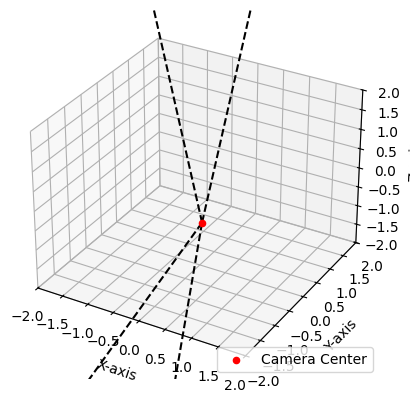

In [45]:
plot_image_plane(K, R, tvec, img_width=5536, img_height=4160)

##### Github Issue Code

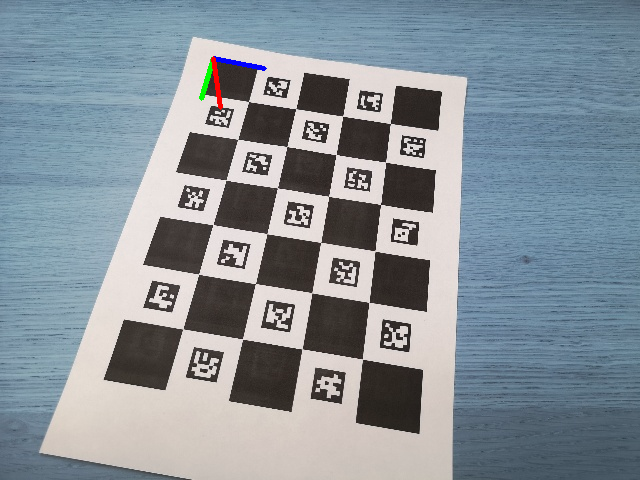

In [10]:
import numpy as np
import cv2 as cv
from cv2 import aruco

file = r"images\test1.jpg"
np_img_3c = cv.imread(file)
np_img_result = np.copy(np_img_3c)

"setup"
arucoDict = aruco.getPredefinedDictionary(aruco.DICT_6X6_250)
arucoParams = aruco.DetectorParameters()

"create the charuco board"
calibration_board = aruco.CharucoBoard((5, 7), squareLength=0.072, markerLength=0.062, dictionary=arucoDict)
board_image = calibration_board.generateImage((500, 700))
cv.imwrite("sample_board.png", board_image)

"create charuco_detector"
charuco_detector = cv.aruco.CharucoDetector(calibration_board, detectorParams=arucoParams)

"camera parameters"
# fx = 1632.677490234375 
# fy = 1632.677490234375 
# cx = 640. 
# cy = 480.
# cameraMatrix = np.array([[fx, 0, cx], [0, fy, cy], [0.,0.,1.]])
# distorsionCoeff = np.array([0.0, 0.0, 0.0, 0.0])


"detect markers and interpolate corners"
charuco_corners, charuco_ids, marker_corners, marker_ids = charuco_detector.detectBoard(np_img_3c)
retval, K, dist_coeffs, _, _ = aruco.calibrateCameraCharuco(
    [charuco_corners], [charuco_ids], board, np_img_result.shape[:2], None, None
)

cameraMatrix = K
distorsionCoeff = dist_coeffs
fx, fy, cx, cy = K[0,0], K[1,1], K[0,-1], K[1,-1]

"draw detected markers"
img2 = aruco.drawDetectedMarkers(np_img_result, marker_corners, marker_ids)
# cv.imwrite("1_detected_markers.png", img2)

"draw detected corners"
img1 = aruco.drawDetectedCornersCharuco(np_img_result, charuco_corners, charuco_ids, (255, 0, 0))
# cv.imwrite("2_detected_markers.png", img1)


"get pose of board"


def matchImagePoints(charuco_board, charuco_corners, charuco_ids):
    objPoints = []
    imgPoints = []
    for i in range(0, len(charuco_ids)):
        index = charuco_ids[i]
        objPoints.append(charuco_board.getChessboardCorners()[index])
        # objPoints[-1][0][1] = charuco_board.getRightBottomCorner()[1] - objPoints[-1][0][1]  # set old axis
        imgPoints.append(charuco_corners[i])
    return np.array(objPoints), np.array(imgPoints)


# objPoints, imgPoints = calibration_board.matchImagePoints(charuco_corners, charuco_ids)
objPoints, imgPoints = matchImagePoints(calibration_board, charuco_corners, charuco_ids)

valid, rvec, tvec = cv.solvePnP(objPoints, imgPoints, cameraMatrix, distorsionCoeff)
img_result = cv.drawFrameAxes(np.copy(np_img_3c), cameraMatrix, distorsionCoeff, rvec, tvec, 0.08)
# cv.imwrite("3_calib_pose.png", img_result)


"get pose of single markers"
estimateParameters = aruco.EstimateParameters()
estimateParameters.pattern = aruco.ARUCO_CW_TOP_LEFT_CORNER
#estimateParameters.pattern = aruco.ARUCO_CCW_CENTER  # set old axis

rvecs, tvecs, objPoints = aruco.estimatePoseSingleMarkers(marker_corners, markerLength=0.062, cameraMatrix=cameraMatrix,
                                                          distCoeffs=distorsionCoeff,
                                                          estimateParameters=estimateParameters)
img_single_pose = np.copy(np_img_3c)
for i in range(len(rvecs)):
    img_single_pose = cv.drawFrameAxes(img_single_pose, cameraMatrix, distorsionCoeff, rvecs[i], tvecs[i], 0.05)

# cv.imwrite("4_calib_single_pose.png", img_single_pose)
Image.fromarray(img_result)

##### Metashape

In [26]:
image = load_image('images\charuco_exp\IMG_9555.JPG', resize=False)
charuco_corners, charuco_ids, marker_corners, marker_ids = decompose_image(image)

for i, pt in enumerate(charuco_corners):
    cv2.circle(image, (int(pt[0][0]), int(pt[0][1])), 30, (0, 255, 0), -1)
    cv2.putText(image, str(charuco_ids[i]), (int(pt[0][0]), int(pt[0][1]) + 20), cv2.FONT_HERSHEY_SIMPLEX, .8, (255, 0, 255), 2)
    
# for i, pts in enumerate(marker_corners):
#     pt1, pt2, pt3, pt4 = pts[0] 
#     '''
#     pt1 = bottom-left
#     pt2 = top-left
#     pt3 = top-right
#     pt3 = bottom-right
#     '''
#     cv2.circle(image, (int(pt1[0]), int(pt1[1])), 5, (255, 0, 0), 5)
#     cv2.circle(image, (int(pt2[0]), int(pt2[1])), 5, (255, 0, 0), 5)
#     cv2.circle(image, (int(pt3[0]), int(pt3[1])), 5, (255, 0, 0), 5)
#     cv2.circle(image, (int(pt4[0]), int(pt4[1])), 5, (255, 0, 0), 5)
#     cv2.putText(image, f"{i}", (int(pt1[0])+20, int(pt1[1])), cv2.FONT_HERSHEY_SIMPLEX, .8, (255, 255, 0), 2)
    
# Image.fromarray(image).resize((image.shape[1]//2, image.shape[0]//2))

<>:1: SyntaxWarning: invalid escape sequence '\c'
<>:1: SyntaxWarning: invalid escape sequence '\c'
C:\Users\Photogauge\AppData\Local\Temp\ipykernel_57740\3218137508.py:1: SyntaxWarning: invalid escape sequence '\c'
  image = load_image('images\charuco_exp\IMG_9555.JPG', resize=False)


In [38]:
corner_map = [
    [1,1,0],
    [1,2,0],
    [1,3,0],
    [1,4,0],
    [2,1,0],
    [2,2,0],
    [2,3,0],
    [2,4,0],
    [3,1,0],
    [3,2,0],
    [3,3,0],
    [3,4,0],
    [4,1,0],
    [4,2,0],
    [4,3,0],
    [4,4,0],
    [5,1,0],
    [5,2,0],
    [5,3,0],
    [5,4,0],
    [6,1,0],
    [6,2,0],
    [6,3,0],
    [6,4,0]
]

corner_map_cm = np.array(
    [[x * 0.04, y*0.04, z*0.04] for x, y, z in corner_map]
)

##### Metashape marker xml format

In [ ]:
#### Camera tags

images = [9552, 9561, 9564, 9572, 9576, 9580, 9583, 9585]

for i, image in enumerate(images):
    print(
        f'<camera id="{i}" sensor_id="0" label="IMG_{image}">\n',
        ' <orientation>1</orientation>\n',
        '</camera>'
    )

In [51]:
#### Point tags

for i in range(24*8):
    print(
        f'<marker id="{i}" label="point {i%24}">'
    )

<marker id="0" label="point 0">
<marker id="1" label="point 1">
<marker id="2" label="point 2">
<marker id="3" label="point 3">
<marker id="4" label="point 4">
<marker id="5" label="point 5">
<marker id="6" label="point 6">
<marker id="7" label="point 7">
<marker id="8" label="point 8">
<marker id="9" label="point 9">
<marker id="10" label="point 10">
<marker id="11" label="point 11">
<marker id="12" label="point 12">
<marker id="13" label="point 13">
<marker id="14" label="point 14">
<marker id="15" label="point 15">
<marker id="16" label="point 16">
<marker id="17" label="point 17">
<marker id="18" label="point 18">
<marker id="19" label="point 19">
<marker id="20" label="point 20">
<marker id="21" label="point 21">
<marker id="22" label="point 22">
<marker id="23" label="point 23">
<marker id="24" label="point 0">
<marker id="25" label="point 1">
<marker id="26" label="point 2">
<marker id="27" label="point 3">
<marker id="28" label="point 4">
<marker id="29" label="point 5">
<marke

In [38]:
## Corner tags
images = [9552, 9561, 9564, 9572, 9576, 9580, 9583, 9585]
image_id = 0

image = load_image(f'images\charuco_exp\IMG_{images[image_id]}.JPG', resize=False)
charuco_corners, _, _, _ = decompose_image(image)
charuco_corners = charuco_corners.squeeze()

for i, pt in enumerate(charuco_corners, start=0):
    print(
        f'<marker marker_id="{i}">',
        f'<location camera_id="{image_id}" pinned="true" x="{pt[0]} y="{pt[1]}"'
        '</marker>',
    )

<>:5: SyntaxWarning: invalid escape sequence '\c'
<>:5: SyntaxWarning: invalid escape sequence '\c'
C:\Users\Photogauge\AppData\Local\Temp\ipykernel_57740\387040092.py:5: SyntaxWarning: invalid escape sequence '\c'
  image = load_image(f'images\charuco_exp\IMG_{images[image_id]}.JPG', resize=False)


<marker marker_id="0"> <location camera_id="0" pinned="true" x="1882.43798828125 y="2882.8681640625"</marker>
<marker marker_id="1"> <location camera_id="0" pinned="true" x="1838.8148193359375 y="2317.08642578125"</marker>
<marker marker_id="2"> <location camera_id="0" pinned="true" x="1794.935546875 y="1751.640625"</marker>
<marker marker_id="3"> <location camera_id="0" pinned="true" x="1749.8741455078125 y="1188.047119140625"</marker>
<marker marker_id="4"> <location camera_id="0" pinned="true" x="2314.63818359375 y="2822.819091796875"</marker>
<marker marker_id="5"> <location camera_id="0" pinned="true" x="2271.512939453125 y="2279.191650390625"</marker>
<marker marker_id="6"> <location camera_id="0" pinned="true" x="2233.710693359375 y="1736.2027587890625"</marker>
<marker marker_id="7"> <location camera_id="0" pinned="true" x="2189.85107421875 y="1195.40869140625"</marker>
<marker marker_id="8"> <location camera_id="0" pinned="true" x="2713.986328125 y="2766.890625"</marker>
<mark

In [30]:
charuco_corners

array([[1882.438 , 2882.8682],
       [1838.8148, 2317.0864],
       [1794.9355, 1751.6406],
       [1749.8741, 1188.0471],
       [2314.6382, 2822.819 ],
       [2271.513 , 2279.1917],
       [2233.7107, 1736.2028],
       [2189.851 , 1195.4087],
       [2713.9863, 2766.8906],
       [2670.0298, 2244.6458],
       [2632.9631, 1722.3098],
       [2593.3315, 1201.9136],
       [3080.8513, 2716.1963],
       [3039.8733, 2212.5415],
       [3008.6658, 1709.6411],
       [2969.3088, 1208.2916],
       [3418.3887, 2668.8323],
       [3383.0842, 2184.907 ],
       [3349.7449, 1700.379 ],
       [3311.2969, 1216.5586],
       [3737.4155, 2630.3726],
       [3706.7358, 2154.3235],
       [3666.3975, 1686.061 ],
       [3640.71  , 1219.3745]], dtype=float32)

##### Metashape Postprocessing

In [16]:
### Helper functions

def load_image(image_path, resize=True):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if resize:
        image = cv2.resize(image, (image.shape[1]//4, image.shape[0]//4))
    return image

def decompose_image(image):
    marker_corners, marker_ids, _ = aruco.detectMarkers(image, dictionary, parameters=params)
    charuco_retval, charuco_corners, charuco_ids = aruco.interpolateCornersCharuco(marker_corners, marker_ids, image, board)
    if charuco_retval:
        return charuco_corners, charuco_ids, marker_corners, marker_ids
    return None, None, None, None

def compute_reprojection_error(object_points, image_points, rvec, tvec, K, dist_coeffs):
    projected_points, _ = cv2.projectPoints(object_points, rvec, tvec, K, dist_coeffs)
    projected_points = projected_points.squeeze()

    errors = np.linalg.norm(image_points - projected_points, axis=1)
    return np.mean(errors)


In [24]:
f = 8679.9558
cx, cy = -37.4562, -32.5196

dist_coeffs = np.array([0.112665, 16.3457, 0., 0., -739.088])

K = np.array([
    [f, 0, cx],
    [0, f, cy],
    [0, 0, 1]
], dtype=np.float32)

corner_map = [
    [1,1,0],
    [1,2,0],
    [1,3,0],
    [1,4,0],
    [2,1,0],
    [2,2,0],
    [2,3,0],
    [2,4,0],
    [3,1,0],
    [3,2,0],
    [3,3,0],
    [3,4,0],
    [4,1,0],
    [4,2,0],
    [4,3,0],
    [4,4,0],
    [5,1,0],
    [5,2,0],
    [5,3,0],
    [5,4,0],
    [6,1,0],
    [6,2,0],
    [6,3,0],
    [6,4,0]
]
corner_map_cm = np.array(
    [[x * 0.04, y*0.04, z*0.04] for x, y, z in corner_map]
)

image = load_image('./images/charuco_exp/IMG_9552.JPG', resize=False)
charuco_corners, _, _, _ = decompose_image(image)
charuco_corners = charuco_corners.squeeze()

ret, rvec, tvec = cv2.solvePnP(corner_map_cm, charuco_corners, K, dist_coeffs)
R, _ = cv2.Rodrigues(rvec)
C = -R.T @ tvec
P = K @ np.hstack((R,tvec))

print("Camera matrix K:\n", K, '\n')
print("- f : ", f)
print("- cx, cy : ", f'({cx}, {cy})', '\n')
print("Distortion coefficients: \n", dist_coeffs, '\n')
print("Rotation matrix R: \n", R, '\n')
print("Translation vector t: \n", tvec, '\n')
print("Camera Position C: \n", C, '\n')
print("Projection Matrix P: \n", P)

Camera matrix K:
 [[ 8.679956e+03  0.000000e+00 -3.745620e+01]
 [ 0.000000e+00  8.679956e+03 -3.251960e+01]
 [ 0.000000e+00  0.000000e+00  1.000000e+00]] 

- f :  8679.9558
- cx, cy :  (-37.4562, -32.5196) 

Distortion coefficients: 
 [ 1.12665e-01  1.63457e+01  0.00000e+00  0.00000e+00 -7.39088e+02] 

Rotation matrix R: 
 [[ 0.60282047  0.26570863  0.75233397]
 [-0.44791823 -0.667617    0.59469051]
 [ 0.66028535 -0.69547571 -0.28343745]] 

Translation vector t: 
 [[0.25483963]
 [0.39118002]
 [1.77573666]] 

Camera Position C: 
 [[-1.15089878]
 [ 1.42842706]
 [ 0.07895472]] 

Projection Matrix P: 
 [[ 5.20772342e+03  2.33238911e+03  6.54084230e+03  2.14548447e+03]
 [-3.90938276e+03 -5.77226960e+03  5.17110479e+03  3.33767912e+03]
 [ 6.60285348e-01 -6.95475715e-01 -2.83437454e-01  1.77573666e+00]]


In [25]:
compute_reprojection_error(corner_map_cm, charuco_corners, rvec, tvec, K, dist_coeffs)

1608.1053859467893